---
# 0. Setup


*   Data Import/Preprocessing
*   Functions



In [1]:
from sklearn.model_selection import train_test_split 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.utils import image_dataset_from_directory
import math
import gc

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
SEED = 42
EPOCHS = 50
BATCH_SIZE = 32
IMG_SIZE = 256
ROOT = "/content/drive/MyDrive/kaggle_bee_vs_wasp/"

In [4]:
#Fix the seed
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [5]:
df = pd.read_csv(ROOT+'labels.csv')
df.head()

,id,path,is_bee,is_wasp,is_otherinsect,is_other,photo_quality,is_validation,is_final_validation,label
0,1,bee1\10007154554_026417cfd0_n.jpg,1,0,0,0,1,0,0,bee
1,2,bee1\10024864894_6dc54d4b34_n.jpg,1,0,0,0,1,0,1,bee
2,3,bee1\10092043833_7306dfd1f0_n.jpg,1,0,0,0,1,1,0,bee
3,4,bee1\1011948979_fc3637e779_w.jpg,1,0,0,0,1,0,1,bee
4,5,bee1\10128235063_dca17db76c_n.jpg,1,0,0,0,1,0,0,bee


In [6]:
for idx in df.index:    
    df.loc[idx,'path']=df.loc[idx,'path'].replace('\\', '/')     
df.head()

,id,path,is_bee,is_wasp,is_otherinsect,is_other,photo_quality,is_validation,is_final_validation,label
0,1,bee1/10007154554_026417cfd0_n.jpg,1,0,0,0,1,0,0,bee
1,2,bee1/10024864894_6dc54d4b34_n.jpg,1,0,0,0,1,0,1,bee
2,3,bee1/10092043833_7306dfd1f0_n.jpg,1,0,0,0,1,1,0,bee
3,4,bee1/1011948979_fc3637e779_w.jpg,1,0,0,0,1,0,1,bee
4,5,bee1/10128235063_dca17db76c_n.jpg,1,0,0,0,1,0,0,bee


In [7]:
def create_datasets(df, img_size):
    imgs = []
    for path in tqdm(df['path']):
        img = cv2.imread(ROOT+path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (img_size,img_size))
        imgs.append(img)
        
    imgs = np.array(imgs, dtype='float32')
    imgs = imgs / 255.0
    df = pd.get_dummies(df['label'])

    return imgs, df

In [8]:
def build_model(img_size, n, output_dim, one_hot=True, num_classes=0):
    input = Input(shape=(img_size,img_size,n))
    resnet = tf.keras.applications.ResNet50(input_shape=(img_size,img_size,n), 
                                            weights='imagenet', 
                                            include_top=False)
    for layer in resnet.layers: layer.trainable = True
    
    x = resnet(input)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.2)(x)
    x = Dense(output_dim, activation='softmax')(x)
    
    if one_hot is False:
      x = Dense(num_classes)(x)

    model = tf.keras.Model(inputs=input, outputs=x) 
    opt = tf.keras.optimizers.SGD(momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

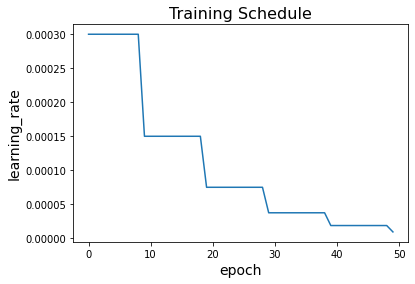

In [9]:
def get_lr_callback(batch_size=32, plot=False):
    start_lr = 3e-4
    def step_decay(epoch):
        drop = 0.5
        epochs_drop = 10.0
        lr = start_lr * math.pow(drop, math.floor((1+epoch)/epochs_drop))
        return lr
    
    lr_callback = tf.keras.callbacks.LearningRateScheduler(step_decay)
    if plot == True:
        rng = [i for i in range(EPOCHS)]
        y = [step_decay(x) for x in rng]
        plt.plot(rng, y)
        plt.xlabel('epoch', size=14)
        plt.ylabel('learning_rate', size=14)
        plt.title('Training Schedule', size=16)
        plt.show()
        
    return lr_callback


get_lr_callback(plot=True)

In [10]:
es_callback = tf.keras.callbacks.EarlyStopping(patience=10, 
                                               verbose=1, 
                                               restore_best_weights=True)

In [11]:
def visualize_learning_history(history):
  '''
  Visualize deep learning accuracy/loss of train/validation datasets over epochs.
  Source: https://www.tensorflow.org/tutorials/images/transfer_learning
  '''
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  plt.ylim([min(plt.ylim()),1])
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylabel('Cross Entropy')
  plt.ylim([0,1.0])
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()

---
# 1. Scikit learn Train_test_split

In [12]:
# Train: 0.7, Validation: 0.15, Test:0.15
train_df, val_df = train_test_split(df, train_size=0.7, random_state=SEED)
val_df, test_df = train_test_split(val_df, train_size=0.5, random_state=SEED)

train_df.reset_index(drop=True)
val_df.reset_index(drop=True)
test_df.reset_index(drop=True)

,id,path,is_bee,is_wasp,is_otherinsect,is_other,photo_quality,is_validation,is_final_validation,label
0,11396,other_noinsect/580248.jpg,0,0,0,1,0,0,0,other
1,10563,other_insect/9955062984_735ded0bd9_m.jpg,0,0,1,0,1,0,1,insect
2,5182,wasp1/853796237_fff6e58dc5_n.jpg,0,1,0,0,1,0,0,wasp
3,4050,wasp1/31870193634_a92cc1c5fb_n.jpg,0,1,0,0,1,0,0,wasp
4,6818,wasp2/I00077.jpg,0,1,0,0,0,0,0,wasp
...,...,...,...,...,...,...,...,...,...,...
1709,24,bee1/10457143913_149e654aaa_n.jpg,1,0,0,0,1,1,0,bee
1710,3959,wasp1/2880978970_1ef8f8c564_n.jpg,0,1,0,0,1,0,0,wasp
1711,2944,bee2/P22578-96r.jpg,1,0,0,0,0,0,0,bee
1712,10359,other_insect/7545957144_5042f84d12_n.jpg,0,0,1,0,1,0,0,insect


In [13]:
train_imgs, train_df = create_datasets(train_df, IMG_SIZE)
val_imgs, val_df = create_datasets(val_df, IMG_SIZE)
test_imgs, test_df = create_datasets(test_df, IMG_SIZE)

100%|██████████| 1714/1714 [02:44<00:00, 10.41it/s]


In [14]:
model = build_model(IMG_SIZE, 3, output_dim=4)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 4)                 8196      
                                                                 
Total params: 23,595,908
Trainable params: 23,542,788
Non-trainable params: 53,120
____________________________________________

Epoch 1/50
250/250 [==============================] - 738s 3s/step - loss: 0.4844 - accuracy: 0.8172 - val_loss: 3.3570 - val_accuracy: 0.2107 - lr: 3.0000e-04
Epoch 2/50
250/250 [==============================] - 728s 3s/step - loss: 0.1834 - accuracy: 0.9405 - val_loss: 1.8336 - val_accuracy: 0.3637 - lr: 3.0000e-04
Epoch 3/50
250/250 [==============================] - 728s 3s/step - loss: 0.1230 - accuracy: 0.9615 - val_loss: 0.5152 - val_accuracy: 0.7904 - lr: 3.0000e-04
Epoch 4/50
250/250 [==============================] - 723s 3s/step - loss: 0.0836 - accuracy: 0.9746 - val_loss: 0.2509 - val_accuracy: 0.9142 - lr: 3.0000e-04
Epoch 5/50
250/250 [==============================] - 723s 3s/step - loss: 0.0616 - accuracy: 0.9809 - val_loss: 0.1912 - val_accuracy: 0.9405 - lr: 3.0000e-04
Epoch 6/50
250/250 [==============================] - 726s 3s/step - loss: 0.0487 - accuracy: 0.9869 - val_loss: 0.1882 - val_accuracy: 0.9399 - lr: 3.0000e-04
Epoch 7/50
250/250 [====================

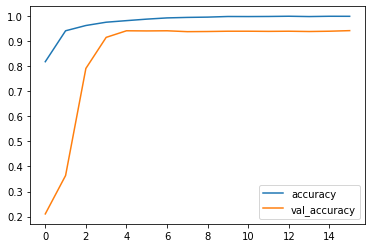

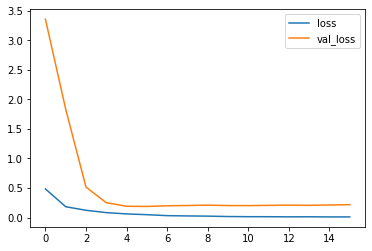

In [15]:
history = model.fit(train_imgs, 
                    train_df, 
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS,
                    callbacks=[es_callback, get_lr_callback(BATCH_SIZE)], 
                    validation_data=(val_imgs, val_df))


pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.show()

In [16]:
model.evaluate(test_imgs, test_df) 

54/54 [==============================] - 27s 485ms/step - loss: 0.1788 - accuracy: 0.9440


[0.17884710431098938, 0.9439906477928162]

---
# 2. High-Quality Photos Only 

In [12]:
# select only high quality photos
df = df.query('photo_quality == 1')
df['label'].value_counts()

bee       2469
insect    2439
wasp      2127
Name: label, dtype: int64

In [13]:
train_df = df.query('is_validation == 0 & is_final_validation == 0').reset_index(drop=True)
val_df = df.query('is_validation == 1').reset_index(drop=True)
test_df = df.query('is_final_validation == 1').reset_index(drop=True)

In [14]:
train_imgs, train_df = create_datasets(train_df, IMG_SIZE)
val_imgs, val_df = create_datasets(val_df, IMG_SIZE)
test_imgs, test_df = create_datasets(test_df, IMG_SIZE)

100%|██████████| 1084/1084 [04:26<00:00,  4.07it/s]


In [15]:
model2 = build_model(IMG_SIZE, 3, output_dim=3)
model2.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 3)                 6147      
                                                                 
Total params: 23,593,859
Trainable params: 23,540,739
Non-trai

Epoch 1/50
154/154 [==============================] - 491s 3s/step - loss: 0.5912 - accuracy: 0.7506 - val_loss: 1.4734 - val_accuracy: 0.3423 - lr: 3.0000e-04
Epoch 2/50
154/154 [==============================] - 505s 3s/step - loss: 0.2661 - accuracy: 0.9053 - val_loss: 2.0169 - val_accuracy: 0.3423 - lr: 3.0000e-04
Epoch 3/50
154/154 [==============================] - 508s 3s/step - loss: 0.1756 - accuracy: 0.9409 - val_loss: 1.7660 - val_accuracy: 0.3739 - lr: 3.0000e-04
Epoch 4/50
154/154 [==============================] - 532s 3s/step - loss: 0.1260 - accuracy: 0.9576 - val_loss: 1.2028 - val_accuracy: 0.4938 - lr: 3.0000e-04
Epoch 5/50
154/154 [==============================] - 514s 3s/step - loss: 0.0897 - accuracy: 0.9723 - val_loss: 0.8559 - val_accuracy: 0.6826 - lr: 3.0000e-04
Epoch 6/50
154/154 [==============================] - 512s 3s/step - loss: 0.0691 - accuracy: 0.9802 - val_loss: 0.4667 - val_accuracy: 0.8274 - lr: 3.0000e-04
Epoch 7/50
154/154 [====================

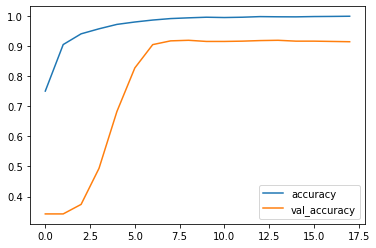

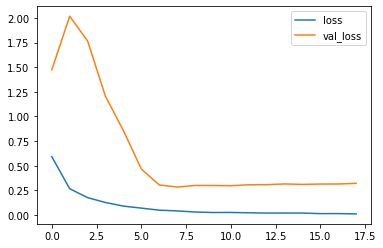

In [16]:
history2 = model2.fit(train_imgs, 
                    train_df, 
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS,
                    callbacks=[es_callback, get_lr_callback(BATCH_SIZE)], 
                    validation_data=(val_imgs, val_df))

pd.DataFrame(history2.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(history2.history)[['loss', 'val_loss']].plot()
plt.show()

In [17]:
model2.evaluate(test_imgs, test_df) 

34/34 [==============================] - 18s 516ms/step - loss: 0.2596 - accuracy: 0.9207


[0.2595682442188263, 0.9206641912460327]

---
# 3. Optimization

---
#4. Extra Test

In [28]:
source_dir = ROOT+'challenge_test/'

path=[]
filelist=os.listdir(source_dir)
for f in filelist:
    fpath=os.path.join('challenge_test/',f)
    path.append(fpath)
Fseries=pd.Series(path, name='test_ds')
df=pd.concat([Fseries], axis=1)

In [44]:
label_col = df.shape[0]*['insect']
df_label = pd.DataFrame(label_col, columns=['label'])

df_test2 = pd.concat([df,df_label], axis=1)
df_test2.rename(columns = {'test_ds':'path'}, inplace = True)

bee_col = df_test2.shape[0]*[0]
df_bee = pd.DataFrame(bee_col, columns=['bee'])
wasp_col = df_test2.shape[0]*[0]
df_wasp = pd.DataFrame(wasp_col, columns=['wasp'])

In [45]:
challenge_imgs, challenge_df = create_datasets(df_test2, IMG_SIZE)

100%|██████████| 37/37 [00:00<00:00, 87.66it/s]


In [46]:
challenge_df = pd.concat([challenge_df,df_bee,df_wasp],axis=1)

In [48]:
cols = train_df.columns
cols

Index(['bee', 'insect', 'wasp'], dtype='object')

In [51]:
challenge_df = challenge_df[cols]
challenge_df.head()

,bee,insect,wasp
0,0,1,0
1,0,1,0
2,0,1,0
3,0,1,0
4,0,1,0


In [52]:
model2.evaluate(challenge_imgs, challenge_df)

2/2 [==============================] - 2s 118ms/step - loss: 2.8728 - accuracy: 0.2432


[2.8728044033050537, 0.2432432472705841]